In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from pathlib import Path
import json

In [2]:
batch_size = 32
img_height = 256
img_width = 256
epochs = 20

DATA_DIR = "./data/"

AUTOTUNE = tf.data.AUTOTUNE

In [4]:
from struct import unpack

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        

for path in Path(DATA_DIR).glob("**/*"):
    if(not path.is_file()):
        continue
    image = JPEG(path) 

    try:
        image.decode()
    except:
        print(path)
        path.unlink()

In [5]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.05,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5790 files belonging to 4 classes.
Using 5501 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.05,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5790 files belonging to 4 classes.
Using 289 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['swap1', 'swap2', 'swap3', 'swap4']


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

In [11]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [12]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20


172/172 [==============================] - 40s 215ms/step - loss: 0.6874 - accuracy: 0.6897 - val_loss: 0.2921 - val_accuracy: 0.9100
Epoch 2/20
172/172 [==============================] - 37s 216ms/step - loss: 0.2377 - accuracy: 0.9013 - val_loss: 0.2255 - val_accuracy: 0.9481
Epoch 3/20
172/172 [==============================] - 38s 219ms/step - loss: 0.1382 - accuracy: 0.9433 - val_loss: 0.1217 - val_accuracy: 0.9550
Epoch 4/20
172/172 [==============================] - 38s 219ms/step - loss: 0.1011 - accuracy: 0.9633 - val_loss: 0.0898 - val_accuracy: 0.9689
Epoch 5/20
172/172 [==============================] - 37s 216ms/step - loss: 0.0852 - accuracy: 0.9709 - val_loss: 0.0326 - val_accuracy: 0.9931
Epoch 6/20
172/172 [==============================] - 37s 217ms/step - loss: 0.0508 - accuracy: 0.9820 - val_loss: 0.0668 - val_accuracy: 0.9654
Epoch 7/20
172/172 [==============================] - 40s 234ms/step - loss: 0.0551 - accuracy: 0.9815 - val_loss: 0.0692 - val_

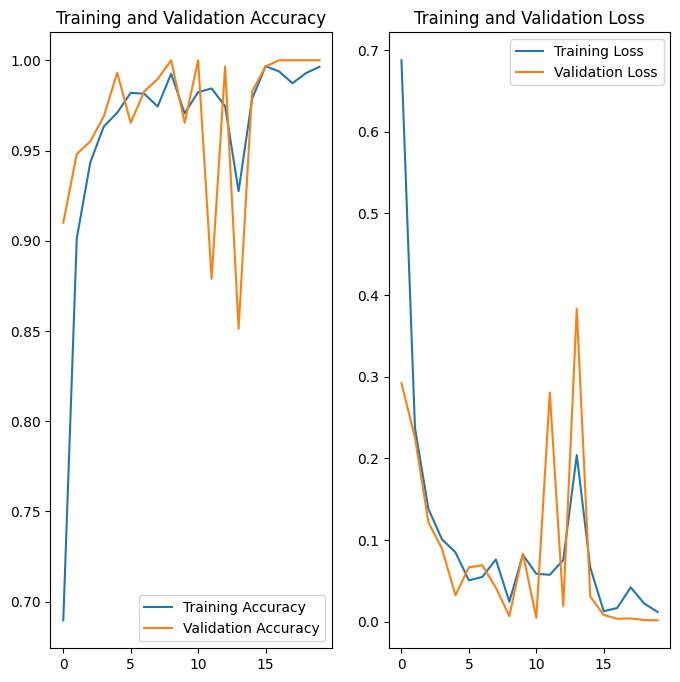

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\karth\AppData\Local\Temp\tmp6qlkg7pn\assets


INFO:tensorflow:Assets written to: C:\Users\karth\AppData\Local\Temp\tmp6qlkg7pn\assets


In [15]:
with open(f"model.tflite", 'wb') as f:
    f.write(tflite_model)

In [16]:
with open("classes.json","w") as fh:
    json.dump(class_names,fh,indent=4)